## **Laboratorio 6**
- Joaquín Campos - 22155
- Sofía García - 22210
- Julio García Salas - 22076

## **Inciso 1 y 2**

In [3]:
# Pasos 1–2 (con detección de codificación y JSON doble)
# - Lee traficogt.txt y tioberny.txt (UTF-16 / UTF-8, etc.)
# - Parseo robusto: JSON array, JSONL, JSON doblemente codificado, o texto plano
# - Normaliza a DataFrame con campos clave para siguientes pasos

from pathlib import Path
import json
import pandas as pd
import re
from typing import List, Dict, Any, Optional, Tuple

# -------------------- Localización de archivos --------------------
def resolve_paths() -> List[Path]:
    local = [Path("traficogt.txt"), Path("tioberny.txt")]
    mnt = [Path("/mnt/data/traficogt.txt"), Path("/mnt/data/tioberny.txt")]
    out = []
    for pl, pm in zip(local, mnt):
        out.append(pl if pl.exists() else (pm if pm.exists() else pl))
    return out

DATA_PATHS = resolve_paths()
OUT_PARQUET = Path("tweets_raw.parquet")
OUT_SAMPLE_CSV = Path("tweets_raw_sample.csv")

# -------------------- Utilidades de lectura/decodificación --------------------
CANDIDATE_ENCODINGS = ["utf-8", "utf-16", "utf-16-le", "utf-16-be", "latin-1"]

def read_text_auto(path: Path) -> Tuple[str, str]:
    """
    Lee bytes y prueba varias codificaciones. Si la decodificación produce muchos \x00,
    intenta con UTF-16 variantes. Devuelve (texto, encoding_usada).
    """
    data = path.read_bytes()
    last_err = None
    # Heurística rápida: si hay muchos 0x00, probablemente es UTF-16
    zero_ratio = data.count(0) / max(1, len(data))
    preferred = (["utf-16"] + CANDIDATE_ENCODINGS) if zero_ratio > 0.01 else CANDIDATE_ENCODINGS
    tried = []
    for enc in preferred:
        try:
            txt = data.decode(enc, errors="strict")
            # si aún hay muchísimos NUL tras decodificar, seguimos probando
            if txt.count("\x00") > 10:
                tried.append((enc, "nul_after_decode"))
                continue
            return txt, enc
        except Exception as e:
            last_err = e
            tried.append((enc, "error"))
            continue
    # fallback permisivo
    return data.decode("utf-8", errors="ignore"), "utf-8(ignore)"

# -------------------- Utilidades de parseo JSON --------------------
def json_maybe_twice(s: str):
    """
    Intenta json.loads; si devuelve un string que comienza con '{' o '[',
    intenta decodificar una segunda vez (JSON doblemente codificado).
    """
    try:
        obj = json.loads(s)
        if isinstance(obj, str):
            st = obj.strip()
            if (st.startswith("{") and st.endswith("}")) or (st.startswith("[") and st.endswith("]")):
                try:
                    return json.loads(st)
                except Exception:
                    return obj
        return obj
    except Exception:
        return None

def read_any_json_whole(raw_stripped: str):
    """Parsea todo el contenido como JSON array/obj (con soporte a doble carga)."""
    obj = json_maybe_twice(raw_stripped)
    if obj is None:
        return None
    if isinstance(obj, list):
        return [x for x in obj if isinstance(x, dict)]
    if isinstance(obj, dict):
        if "tweets" in obj and isinstance(obj["tweets"], list):
            return [x for x in obj["tweets"] if isinstance(x, dict)]
        if "data" in obj and isinstance(obj["data"], list):
            return [x for x in obj["data"] if isinstance(x, dict)]
        return [obj]
    return None

def read_jsonl_lines(raw: str):
    """JSONL: una entrada por línea; soporta doble decodificación."""
    recs = []
    ok = 0
    for line in raw.splitlines():
        s = line.strip().rstrip(",")
        if not s:
            continue
        obj = json_maybe_twice(s)
        if isinstance(obj, dict):
            recs.append(obj); ok += 1
    return recs, ok

def extract_json_from_line(line: str):
    """Intenta rescatar el primer bloque {...} o [...] de una línea y decodificarlo."""
    s = line.strip()
    start_obj = s.find("{"); end_obj = s.rfind("}")
    start_arr = s.find("["); end_arr = s.rfind("]")
    cand = None
    if start_obj != -1 and end_obj > start_obj:
        cand = s[start_obj:end_obj+1]
    elif start_arr != -1 and end_arr > start_arr:
        cand = s[start_arr:end_arr+1]
    if cand:
        return json_maybe_twice(cand)
    return None

# -------------------- Normalización de registros --------------------
def norm_username(u: Optional[str]) -> Optional[str]:
    if not u:
        return u
    u = u.strip()
    if u.startswith("@"):
        u = u[1:]
    return u.lower()

def extract_list_usernames(mentioned: Any) -> List[str]:
    out: List[str] = []
    if isinstance(mentioned, list):
        for m in mentioned:
            if isinstance(m, dict):
                un = m.get("username") or m.get("screen_name") or m.get("name")
                if un: out.append(norm_username(un))
            elif isinstance(m, str):
                out.append(norm_username(m))
    return [x for x in out if x]

def hashtags_to_list(h: Any) -> List[str]:
    out: List[str] = []
    if isinstance(h, list):
        for item in h:
            if isinstance(item, str):
                out.append(item.lstrip("#").lower())
            elif isinstance(item, dict):
                txt = item.get("text") or item.get("tag")
                if txt: out.append(str(txt).lstrip("#").lower())
    return out

def get_text(rec: Dict[str, Any]) -> Optional[str]:
    for k in ("rawContent", "full_text", "text"):
        val = rec.get(k)
        if isinstance(val, str) and val.strip():
            return val
    return None

def get_user_obj(rec: Dict[str, Any]) -> Optional[Dict[str, Any]]:
    u = rec.get("user")
    return u if isinstance(u, dict) else None

def safe_int(x):
    try: return int(x)
    except Exception: return None

MENTION_RE = re.compile(r"@([A-Za-z0-9_]{1,15})")
HASHTAG_RE = re.compile(r"#([A-Za-z0-9_]+)")

def rows_from_json(records: List[Dict[str, Any]], source_file: str) -> List[Dict[str, Any]]:
    rows: List[Dict[str, Any]] = []
    for r in records:
        u = get_user_obj(r)
        uname = u.get("username") or u.get("screen_name") or u.get("name") if u else None
        uid = u.get("id") or u.get("id_str") if u else None

        # Mentions de diferentes formatos
        mentions = []
        if "mentionedUsers" in r:
            mentions = extract_list_usernames(r.get("mentionedUsers"))
        elif "entities" in r and isinstance(r["entities"], dict):
            mentions = extract_list_usernames(r["entities"].get("user_mentions"))

        # Hashtags
        if "hashtags" in r:
            tags = hashtags_to_list(r.get("hashtags"))
        elif "entities" in r and isinstance(r["entities"], dict):
            tags = hashtags_to_list(r["entities"].get("hashtags"))
        else:
            tags = []

        # RT / Quote
        rt = r.get("retweetedTweet") or r.get("retweeted_status")
        qt = r.get("quotedTweet") or r.get("quoted_status")
        is_rt = rt is not None
        is_qt = qt is not None
        rt_user = norm_username((rt or {}).get("user", {}).get("username") if isinstance(rt, dict) else None)
        qt_user = norm_username((qt or {}).get("user", {}).get("username") if isinstance(qt, dict) else None)

        # Reply
        in_reply_to_user = r.get("inReplyToUser")
        reply_to_username = None
        if isinstance(in_reply_to_user, dict):
            reply_to_username = norm_username(in_reply_to_user.get("username"))
        if not reply_to_username and r.get("in_reply_to_screen_name"):
            reply_to_username = norm_username(r.get("in_reply_to_screen_name"))

        # Métricas
        like_count  = safe_int(r.get("likeCount")   or r.get("favorite_count"))
        rt_count    = safe_int(r.get("retweetCount")or r.get("retweet_count"))
        reply_count = safe_int(r.get("replyCount")  or r.get("reply_count"))
        quote_count = safe_int(r.get("quoteCount")  or r.get("quote_count"))
        view_count  = safe_int(r.get("viewCount")   or r.get("views"))

        # Fecha
        date_raw = r.get("date") or r.get("created_at")
        try:    date_parsed = pd.to_datetime(date_raw)
        except: date_parsed = pd.NaT

        rows.append({
            "source_file": source_file,
            "tweet_id": r.get("id") or r.get("id_str"),
            "date": date_parsed,
            "lang": r.get("lang"),
            "username": norm_username(uname),
            "user_id": uid,
            "text": get_text(r),
            "mentions": mentions,
            "hashtags": tags,
            "is_retweet": bool(is_rt),
            "is_quote": bool(is_qt),
            "retweeted_user": rt_user,
            "quoted_user": qt_user,
            "reply_to_user": reply_to_username,
            "in_reply_to_tweet_id": r.get("inReplyToTweetId") or r.get("in_reply_to_status_id_str") or r.get("in_reply_to_status_id"),
            "like_count": like_count,
            "retweet_count": rt_count,
            "reply_count": reply_count,
            "quote_count": quote_count,
            "view_count": view_count,
            "raw_record": r,
        })
    return rows

def rows_from_plaintext(lines: List[str], source_file: str) -> List[Dict[str, Any]]:
    rows = []
    for i, raw in enumerate(lines, start=1):
        txt = raw.strip()
        if not txt:
            continue
        # RT al inicio
        is_rt = False; rt_user = None
        m_rt = re.match(r"^\s*RT\s+@([A-Za-z0-9_]{1,15})\b", txt)
        if m_rt:
            is_rt = True; rt_user = m_rt.group(1).lower()
        # menciones / hashtags
        mentions = [m.lower() for m in MENTION_RE.findall(txt)]
        hashtags = [h.lower() for h in HASHTAG_RE.findall(txt)]
        # reply si inicia con @
        reply_to_user = None
        m_reply = re.match(r"^\s*@([A-Za-z0-9_]{1,15})\b", txt)
        if m_reply:
            reply_to_user = m_reply.group(1).lower()

        rows.append({
            "source_file": source_file,
            "tweet_id": f"{source_file}:{i}",
            "date": pd.NaT,
            "lang": None,
            "username": None,
            "user_id": None,
            "text": txt,
            "mentions": mentions,
            "hashtags": hashtags,
            "is_retweet": is_rt,
            "is_quote": False,
            "retweeted_user": rt_user,
            "quoted_user": None,
            "reply_to_user": reply_to_user,
            "in_reply_to_tweet_id": None,
            "like_count": None,
            "retweet_count": None,
            "reply_count": None,
            "quote_count": None,
            "view_count": None,
            "raw_record": {"_raw_line": txt},
        })
    return rows

# -------------------- Proceso principal de carga --------------------
all_rows: List[Dict[str, Any]] = []
summary = []

for p in DATA_PATHS:
    status = "NO_FILE"
    n_lines = 0; n_json_whole = 0; n_jsonl = 0; n_json_inline = 0; used_plain = 0
    encoding_used = "-"
    if p.exists():
        status = "OK"
        raw, encoding_used = read_text_auto(p)
        lines = raw.splitlines()
        n_lines = len(lines)

        # 1) JSON global (array/obj)
        recs = read_any_json_whole(raw.strip())
        if isinstance(recs, list) and recs:
            all_rows.extend(rows_from_json(recs, p.name))
            n_json_whole = len(recs)
        else:
            # 2) JSONL
            recs_jsonl, ok = read_jsonl_lines(raw)
            if ok > 0:
                all_rows.extend(rows_from_json(recs_jsonl, p.name))
                n_jsonl = ok
            else:
                # 3) Por línea: JSON embebido o texto plano
                temp_rows = []
                for line in lines:
                    obj = extract_json_from_line(line)
                    if isinstance(obj, dict):
                        temp_rows.extend(rows_from_json([obj], p.name))
                        n_json_inline += 1
                    else:
                        temp_rows.extend(rows_from_plaintext([line], p.name))
                        used_plain += 1
                all_rows.extend(temp_rows)

    summary.append({
        "file": p.name, "status": status, "encoding": encoding_used,
        "n_lines": n_lines, "JSON_global": n_json_whole, "JSONL": n_jsonl,
        "JSON_inline": n_json_inline, "texto_plano": used_plain
    })

# -------------------- DataFrame & salidas --------------------
df = pd.DataFrame(all_rows)
if not df.empty and "date" in df.columns:
    df = df.sort_values("date", na_position="last").reset_index(drop=True)

if not df.empty:
    df.head(50).to_csv(OUT_SAMPLE_CSV, index=False)
    try:
        df.to_parquet(OUT_PARQUET, index=False)
        parquet_path = str(OUT_PARQUET.resolve())
    except Exception:
        parquet_path = "(No Parquet: instala 'pyarrow' o 'fastparquet')"
else:
    parquet_path = "(DataFrame vacío)"

print("=== RESUMEN DE CARGA (Paso 1–2) ===")
print("Archivos buscados:")
for p in DATA_PATHS: print(" -", p)

for s in summary:
    print(f"- {s['file']:15s} | estado={s['status']:7s} | codif={s['encoding']:10s} | "
          f"líneas={s['n_lines']:5d} | JSON_global={s['JSON_global']:5d} | "
          f"JSONL={s['JSONL']:5d} | JSON_inline={s['JSON_inline']:5d} | "
          f"texto_plano={s['texto_plano']:5d}")

print(f"\nTotal de filas normalizadas: {len(df):,}")
if not df.empty:
    print("Columnas:", list(df.columns))
    print(f"Muestra CSV (50 filas): {str(OUT_SAMPLE_CSV.resolve())}")
    print(f"Parquet: {parquet_path}")
else:
    print("Nota: DataFrame vacío. Si sigue vacío, compárteme 10–15 líneas crudas de un archivo.")


=== RESUMEN DE CARGA (Paso 1–2) ===
Archivos buscados:
 - traficogt.txt
 - tioberny.txt
- traficogt.txt   | estado=OK      | codif=utf-16     | líneas= 5605 | JSON_global=    0 | JSONL= 5604 | JSON_inline=    0 | texto_plano=    0
- tioberny.txt    | estado=OK      | codif=utf-16     | líneas= 5019 | JSON_global=    0 | JSONL= 5019 | JSON_inline=    0 | texto_plano=    0

Total de filas normalizadas: 10,623
Columnas: ['source_file', 'tweet_id', 'date', 'lang', 'username', 'user_id', 'text', 'mentions', 'hashtags', 'is_retweet', 'is_quote', 'retweeted_user', 'quoted_user', 'reply_to_user', 'in_reply_to_tweet_id', 'like_count', 'retweet_count', 'reply_count', 'quote_count', 'view_count', 'raw_record']
Muestra CSV (50 filas): C:\Users\garci\OneDrive\Documentos\Tercer semestre U\IALab4\lab6ds\tweets_raw_sample.csv
Parquet: (No Parquet: instala 'pyarrow' o 'fastparquet')


## **Inciso 3**

In [4]:
# Inciso 3 (3.1, 3.2, 3.3): Limpieza, extracción y normalización
# - Convierte a minúsculas, quita URLs, emojis, puntuación, stopwords y números (opcional)
# - Extrae/normaliza menciones, respuestas y retweets (rellena desde texto si falta)
# - Elimina duplicados de tweets y normaliza nombres de usuario/menciones
# - Deja columnas listas para el siguiente inciso (3.4)
#
# 👉 Al terminar imprime "RESUMEN PREPROCESAMIENTO (3.1–3.3)".
#    Pégame ese bloque aquí para analizar y seguimos con 3.4.

import re, json, ast
import pandas as pd
from pathlib import Path

# =========================
# 0) Recupera df si no existe (vuelve a parsear JSONL UTF-16)
# =========================
def read_text_auto(path: Path):
    data = path.read_bytes()
    zero_ratio = data.count(0) / max(1, len(data))
    cands = (["utf-16","utf-16-le","utf-16-be","utf-8","latin-1"]
             if zero_ratio > 0.01 else ["utf-8","utf-16","utf-16-le","utf-16-be","latin-1"])
    for enc in cands:
        try:
            txt = data.decode(enc)
            if txt.count("\x00") > 10:
                continue
            return txt
        except Exception:
            continue
    return data.decode("utf-8", errors="ignore")

def json_maybe_twice(s: str):
    try:
        obj = json.loads(s)
        if isinstance(obj, str):
            st = obj.strip()
            if (st.startswith("{") and st.endswith("}")) or (st.startswith("[") and st.endswith("]")):
                try: return json.loads(st)
                except Exception: return obj
        return obj
    except Exception:
        return None

def load_jsonl_utf16(paths):
    rows = []
    for p in paths:
        if not Path(p).exists():
            continue
        raw = read_text_auto(Path(p))
        for line in raw.splitlines():
            s = line.strip().rstrip(",")
            if not s: 
                continue
            obj = json_maybe_twice(s)
            if not isinstance(obj, dict):
                continue
            r = obj
            # username
            u = r.get("user") if isinstance(r.get("user"), dict) else {}
            uname = (u.get("username") or u.get("screen_name") or u.get("name"))
            # mentions
            mentions = []
            if "mentionedUsers" in r and isinstance(r["mentionedUsers"], list):
                for m in r["mentionedUsers"]:
                    if isinstance(m, dict):
                        un = m.get("username") or m.get("screen_name") or m.get("name")
                        if un: mentions.append(un.lower().lstrip("@"))
            elif "entities" in r and isinstance(r["entities"], dict):
                for m in (r["entities"].get("user_mentions") or []):
                    if isinstance(m, dict):
                        un = m.get("screen_name") or m.get("username") or m.get("name")
                        if un: mentions.append(un.lower().lstrip("@"))
            # hashtags
            tags = []
            if isinstance(r.get("hashtags"), list):
                for h in r["hashtags"]:
                    if isinstance(h, str): tags.append(h.lstrip("#").lower())
                    elif isinstance(h, dict):
                        t = h.get("text") or h.get("tag")
                        if t: tags.append(str(t).lstrip("#").lower())
            elif "entities" in r and isinstance(r["entities"], dict):
                for h in (r["entities"].get("hashtags") or []):
                    if isinstance(h, str): tags.append(h.lstrip("#").lower())
                    elif isinstance(h, dict):
                        t = h.get("text") or h.get("tag")
                        if t: tags.append(str(t).lstrip("#").lower())
            # retweet / quote
            rt = r.get("retweetedTweet") or r.get("retweeted_status")
            qt = r.get("quotedTweet") or r.get("quoted_status")
            rt_user = (rt or {}).get("user", {})
            qt_user = (qt or {}).get("user", {})
            # reply
            reply_to = None
            if isinstance(r.get("inReplyToUser"), dict):
                reply_to = r["inReplyToUser"].get("username")
            if not reply_to and isinstance(r.get("inReplyToUser"), dict):
                reply_to = r["inReplyToUser"].get("screen_name")
            if not reply_to and r.get("in_reply_to_screen_name"):
                reply_to = r.get("in_reply_to_screen_name")

            def norm_user(x):
                if not x: return None
                x = str(x).strip()
                if x.startswith("@"): x = x[1:]
                return x.lower()

            rows.append({
                "source_file": Path(p).name,
                "tweet_id": r.get("id") or r.get("id_str"),
                "date": pd.to_datetime(r.get("date") or r.get("created_at"), errors="coerce"),
                "lang": r.get("lang"),
                "username": norm_user(uname),
                "user_id": (u.get("id") or u.get("id_str")) if isinstance(u, dict) else None,
                "text": (r.get("rawContent") or r.get("full_text") or r.get("text")),
                "mentions": [m for m in mentions if m],
                "hashtags": [t for t in tags if t],
                "is_retweet": rt is not None,
                "is_quote": qt is not None,
                "retweeted_user": norm_user(rt_user.get("username") if isinstance(rt_user, dict) else None),
                "quoted_user": norm_user(qt_user.get("username") if isinstance(qt_user, dict) else None),
                "reply_to_user": norm_user(reply_to),
                "in_reply_to_tweet_id": r.get("inReplyToTweetId") or r.get("in_reply_to_status_id") or r.get("in_reply_to_status_id_str"),
                "like_count": r.get("likeCount") or r.get("favorite_count"),
                "retweet_count": r.get("retweetCount") or r.get("retweet_count"),
                "reply_count": r.get("replyCount") or r.get("reply_count"),
                "quote_count": r.get("quoteCount") or r.get("quote_count"),
                "view_count": r.get("viewCount") or r.get("views"),
            })
    return pd.DataFrame(rows)

try:
    df
    assert isinstance(df, pd.DataFrame) and not df.empty
except Exception:
    df = load_jsonl_utf16(["traficogt.txt","/mnt/data/traficogt.txt",
                           "tioberny.txt","/mnt/data/tioberny.txt"])

# =========================
# 1) Funciones de limpieza
# =========================
# Fix de mojibake (p. ej., "TÃ©cnica" -> "Técnica")
def fix_mojibake(s):
    if not isinstance(s, str): 
        return s
    if "Ã" in s or "Â" in s or "ðŸ" in s:
        try:
            return s.encode("latin1", errors="ignore").decode("utf-8", errors="ignore")
        except Exception:
            return s
    return s

URL_RE = re.compile(r"https?://\S+|www\.\S+", re.IGNORECASE)
EMOJI_RE = re.compile(
    "["                         # bloques comunes de emoji
    "\U0001F600-\U0001F64F"     # emoticonos
    "\U0001F300-\U0001F5FF"     # símbolos & pictogramas
    "\U0001F680-\U0001F6FF"     # transporte
    "\U0001F1E0-\U0001F1FF"     # banderas
    "\U00002700-\U000027BF"     # otros
    "\U000024C2-\U0001F251"
    "]+", flags=re.UNICODE
)
# Mantener letras (incl. acentos) y espacios; quitar dígitos y puntuación
KEEP_LETTERS_RE = re.compile(r"[^a-záéíóúüñ\s]")

STOP_ES = set("""
a al algo algunas algunos ante antes apenas aquella aquellas aquello aquellos aqui
así aun aunque cada casi como con contigo contra cual cuales cualquier cuando
de del desde donde dos el ella ellas ellos en entre era erais eran eras eres es esa
esas ese eso esos esta estaba estabais estaban estabas estamos estan estaré estarás
este esto estos estuvo fui fue fueron hemos han hasta hay hice hizo hoy la las le les
lo los me mi mis mucha muchas mucho muchos muy nada ni no nosotros nosotras nuestra
nuestro nuestras nuestros nunca o os para pero poco por porque que quien quienes se
sea sean según ser si siempre sin sino sobre sois son soy su sus también te tengo tiene
tienen toda todas todo todos tras tu tus un una uno unos usted ustedes ya y yo
""".split())

def clean_text(s: str):
    if not isinstance(s, str) or not s.strip():
        return ""
    s = fix_mojibake(s)
    s = s.lower()
    s = URL_RE.sub(" ", s)
    s = EMOJI_RE.sub(" ", s)
    # Quitar @ y # del texto (las menciones/hashtags se quedan en columnas aparte)
    s = s.replace("@", " ").replace("#", " ")
    # Quitar apóstrofes simples/raros
    s = s.replace("’", "").replace("‘", "").replace("´","").replace("`","").replace("'", "")
    # Quitar puntuación y números (si deseas conservar números, comenta la siguiente línea y usa otra regex)
    s = KEEP_LETTERS_RE.sub(" ", s)
    # Normalizar espacios
    s = re.sub(r"\s+", " ", s).strip()
    return s

def ensure_list(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        try:
            val = ast.literal_eval(x)
            if isinstance(val, list): 
                return val
        except Exception:
            return []
    return []

def norm_user(u):
    if not u: return None
    u = str(u).strip()
    if u.startswith("@"): u = u[1:]
    return u.lower()

# =========================
# 2) Aplicar preprocesamiento
# =========================
df_proc = df.copy()

# Arregla mojibake en campos de texto/usuario que lo requieran
for col in ["text","username","retweeted_user","quoted_user","reply_to_user"]:
    if col in df_proc.columns:
        df_proc[col] = df_proc[col].apply(lambda x: fix_mojibake(x) if isinstance(x,str) else x)

# Asegura listas en menciones/hashtags
if "mentions" in df_proc.columns:
    df_proc["mentions"] = df_proc["mentions"].apply(ensure_list).apply(lambda xs: [norm_user(x) for x in xs if x])
else:
    df_proc["mentions"] = [[] for _ in range(len(df_proc))]

if "hashtags" in df_proc.columns:
    df_proc["hashtags"] = df_proc["hashtags"].apply(ensure_list).apply(
        lambda xs: [fix_mojibake(x).lstrip("#").lower() for x in xs if isinstance(x,str) and x]
    )
else:
    df_proc["hashtags"] = [[] for _ in range(len(df_proc))]

# 3.2 Completa menciones, respuestas y RT desde el texto si faltan
MENTION_RE = re.compile(r"@([A-Za-z0-9_]{1,15})")
def backfill_from_text(row):
    txt = row.get("text") or ""
    # menciones desde texto
    if isinstance(txt, str) and txt:
        found = [m.lower() for m in MENTION_RE.findall(txt)]
    else:
        found = []
    # union de las ya existentes con las del texto
    cur = set([m for m in row["mentions"] if m])
    cur.update(found)
    row["mentions"] = sorted(cur)

    # reply si inicia con @user
    m = re.match(r"^\s*@([A-Za-z0-9_]{1,15})\b", txt or "")
    if not row.get("reply_to_user") and m:
        row["reply_to_user"] = norm_user(m.group(1))

    # RT si inicia con "RT @user:"
    m2 = re.match(r"^\s*rt\s+@([A-Za-z0-9_]{1,15})\b", (txt or "").lower())
    if (not row.get("is_retweet")) and m2:
        row["is_retweet"] = True
        row["retweeted_user"] = norm_user(m2.group(1))
    return row

df_proc = df_proc.apply(backfill_from_text, axis=1)

# 3.1 Limpieza de texto
df_proc["text_clean"] = df_proc["text"].apply(clean_text)

# Tokens (separación simple por espacio)
df_proc["tokens"] = df_proc["text_clean"].apply(lambda s: [t for t in s.split() if t])

# Stopwords
df_proc["tokens_nostop"] = df_proc["tokens"].apply(lambda ts: [t for t in ts if t not in STOP_ES])

# 3.3 Normalización de usuarios y eliminación de duplicados
for col in ["username","reply_to_user","retweeted_user","quoted_user"]:
    if col in df_proc.columns:
        df_proc[col] = df_proc[col].apply(norm_user)

n_raw = len(df_proc)
# elimina duplicados por tweet_id si existe, si no por (source_file,text)
if "tweet_id" in df_proc.columns:
    df_proc = df_proc.drop_duplicates(subset=["tweet_id"])
else:
    df_proc = df_proc.drop_duplicates(subset=["source_file","text"])
n_after_dedup = len(df_proc)
dup_removed = n_raw - n_after_dedup

# =========================
# 3) Resumen para reporte
# =========================
n_with_mentions = int((df_proc["mentions"].apply(len) > 0).sum())
n_with_reply = int(df_proc["reply_to_user"].notna().sum())
n_is_rt = int(df_proc["is_retweet"].fillna(False).sum())

# hashtags más frecuentes (top 10)
from collections import Counter
ht_counts = Counter(h for xs in df_proc["hashtags"] for h in (xs or []))
top_hashtags = ht_counts.most_common(10)

print("=== RESUMEN PREPROCESAMIENTO (3.1–3.3) ===")
print(f"Filas originales: {n_raw:,}")
print(f"Duplicados removidos: {dup_removed:,}")
print(f"Filas finales: {n_after_dedup:,}")
print(f"Tweets con menciones: {n_with_mentions:,}")
print(f"Tweets que son replies: {n_with_reply:,}")
print(f"Tweets que son retweets: {n_is_rt:,}")
print("\nTop 10 hashtags (después de limpieza):")
for tag, cnt in top_hashtags:
    print(f"  #{tag}: {cnt}")

# Vista rápida de ejemplos (5)
print("\nEjemplos de 'text'  →  'text_clean' (5 filas):")
for i, row in df_proc.head(5).iterrows():
    print(f"- {row.get('text')!r}  ->  {row.get('text_clean')!r}")

# Guarda muestra para inspección manual (opcional)
df_proc.head(200).to_csv("tweets_clean_sample.csv", index=False)
print("\nArchivo de muestra (200 filas) guardado en: tweets_clean_sample.csv")

# Mantener df_proc en memoria para el siguiente inciso (3.4)


=== RESUMEN PREPROCESAMIENTO (3.1–3.3) ===
Filas originales: 10,623
Duplicados removidos: 84
Filas finales: 10,539
Tweets con menciones: 9,294
Tweets que son replies: 8,552
Tweets que son retweets: 0

Top 10 hashtags (después de limpieza):
  #guatemala: 40
  #ahora: 36
  #urgente: 33
  #guatemalasaleadelante: 24
  #traficogt: 22
  #ahoralh: 19
  #minfinsaleadelante: 17
  #renunciengolpistas: 15
  #presupuesto2025: 14
  #unpresupuestoparalapoblación: 13

Ejemplos de 'text'  →  'text_clean' (5 filas):
- 'Presidente Jimmy Morales preside Mesa Técnica de Alto Nivel de Gobierno Abierto @GuatemalaGob @OgpGuatemala https://t.co/nSkq2OZXfM'  ->  'presidente jimmy morales preside mesa técnica de alto nivel de gobierno abierto guatemalagob ogpguatemala'
- '#ÚltimaHora: Este es el momento en que un manifestante empuja al director de la PNC, Nery Ramos.\n\nVía: @LesterRamirezEU. https://t.co/42CiQfXwY8'  ->  'últimahora este es el momento en que un manifestante empuja al director de la pnc nery ra

## **Inciso 4A**

<Figure size 640x480 with 0 Axes>

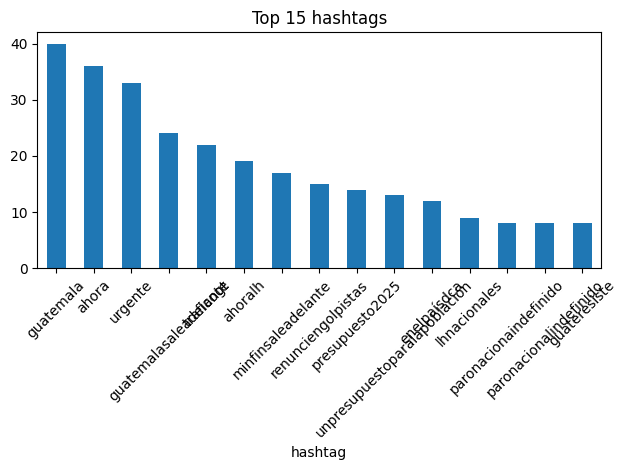

<Figure size 640x480 with 0 Axes>

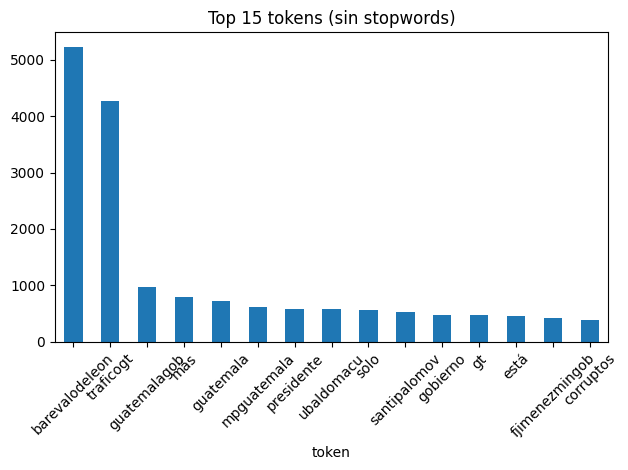

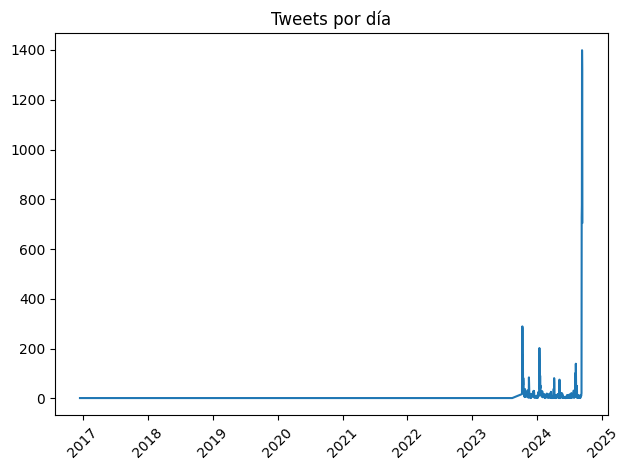

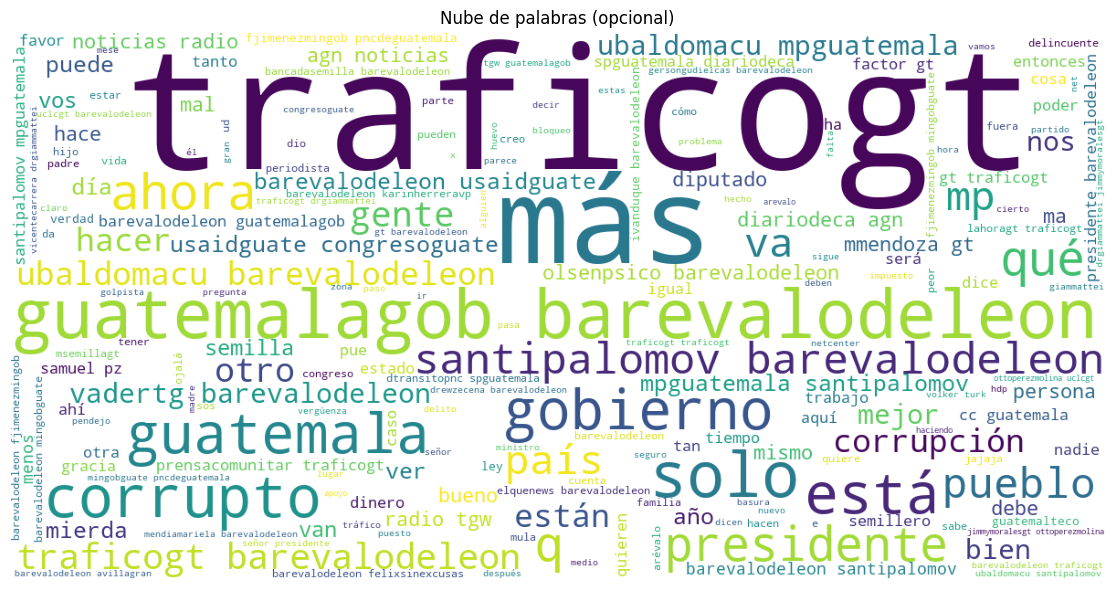

=== RESUMEN EDA (4.1) ===
Tweets totales: 10,539
Usuarios únicos (emitentes): 4,291
Menciones totales: 28,037 | Usuarios distintos mencionados: 1,856
Tweets que son replies: 8,552
Tweets que son retweets: 0

Top 10 hashtags:
  #guatemala: 40
  #ahora: 36
  #urgente: 33
  #guatemalasaleadelante: 24
  #traficogt: 22
  #ahoralh: 19
  #minfinsaleadelante: 17
  #renunciengolpistas: 15
  #presupuesto2025: 14
  #unpresupuestoparalapoblación: 13

Top 10 usuarios por # de tweets:
  @traficogt: 781
  @batallonjalapa: 134
  @mildred_gaitan: 105
  @lahoragt: 74
  @chofito63569841: 49
  @angeln8: 46
  @prensacomunitar: 45
  @papaabumario: 43
  @elrevoltijogt: 40
  @hellboy17oc: 39

Top 10 usuarios más mencionados:
  @barevalodeleon: 5168
  @traficogt: 4232
  @guatemalagob: 961
  @mpguatemala: 602
  @ubaldomacu: 572
  @santipalomov: 518
  @fjimenezmingob: 411
  @drgiammattei: 318
  @mingobguate: 309
  @congresoguate: 309

Archivos generados en: C:\Users\garci\OneDrive\Documentos\Tercer semestre U\IA

In [5]:
# === Celda A — Inciso 4.1: Análisis Exploratorio (EDA) ===
# - Usa df_proc de la celda anterior; si no existe, intenta reconstruirlo rápido desde los txt.
# - Calcula: cuentas básicas, top hashtags, top tokens, top usuarios, timeline, interacciones.
# - Genera gráficos (matplotlib) y guarda CSV/PNGs para documentación.
#
# Al final imprime: "RESUMEN EDA (4.1)"

import pandas as pd
import numpy as np
import re
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

# ---------- Helpers de carga mínima (por si abres el notebook desde cero) ----------
def _ensure_df_proc():
    global df_proc
    if "df_proc" in globals() and isinstance(df_proc, pd.DataFrame) and not df_proc.empty:
        return df_proc

    # Fallback 1: si dejaste la muestra limpia
    if Path("tweets_clean_sample.csv").exists():
        tmp = pd.read_csv("tweets_clean_sample.csv")
        # columnas listas
        for col in ["mentions","hashtags","tokens","tokens_nostop"]:
            if col in tmp.columns:
                tmp[col] = tmp[col].apply(lambda x: [] if pd.isna(x) else eval(x) if isinstance(x,str) else [])
        # normaliza fechas
        if "date" in tmp.columns:
            tmp["date"] = pd.to_datetime(tmp["date"], errors="coerce")
        dfp = tmp
        return dfp

    # Fallback 2 (reconstrucción mínima): vuelve a leer JSONL UTF-16 y limpia básico
    import json
    def _read_bytes_auto(path: Path) -> str:
        data = path.read_bytes()
        if data.count(0)/max(1,len(data)) > 0.01:
            for enc in ["utf-16","utf-16-le","utf-16-be","utf-8","latin-1"]:
                try:
                    s = data.decode(enc)
                    if s.count("\x00") < 5: return s
                except: pass
            return data.decode("utf-16", errors="ignore")
        return data.decode("utf-8", errors="ignore")
    def _json_maybe_twice(s):
        try:
            o = json.loads(s)
            if isinstance(o,str) and o.strip() and o.strip()[0] in "{[":
                try: return json.loads(o)
                except: return o
            return o
        except: return None

    rows=[]
    for p in ["traficogt.txt","/mnt/data/traficogt.txt","tioberny.txt","/mnt/data/tioberny.txt"]:
        p=Path(p)
        if not p.exists(): continue
        raw=_read_bytes_auto(p)
        for line in raw.splitlines():
            s=line.strip().rstrip(",")
            if not s: continue
            obj=_json_maybe_twice(s)
            if not isinstance(obj,dict): continue
            r=obj; u=r.get("user") if isinstance(r.get("user"),dict) else {}
            def _norm(u):
                if not u: return None
                u=str(u).strip()
                if u.startswith("@"): u=u[1:]
                return u.lower()
            # mentions
            m=[]
            if "mentionedUsers" in r and isinstance(r["mentionedUsers"],list):
                for it in r["mentionedUsers"]:
                    if isinstance(it,dict):
                        un=it.get("username") or it.get("screen_name") or it.get("name")
                        if un: m.append(_norm(un))
            # hashtags
            hs=[]
            if isinstance(r.get("hashtags"),list):
                for h in r["hashtags"]:
                    if isinstance(h,str): hs.append(h.lstrip("#").lower())
                    elif isinstance(h,dict):
                        t=h.get("text") or h.get("tag")
                        if t: hs.append(str(t).lstrip("#").lower())
            rows.append({
                "source_file": p.name,
                "tweet_id": r.get("id") or r.get("id_str"),
                "date": pd.to_datetime(r.get("date") or r.get("created_at"), errors="coerce"),
                "lang": r.get("lang"),
                "username": _norm((u.get("username") or u.get("screen_name") or u.get("name")) if u else None),
                "text": (r.get("rawContent") or r.get("full_text") or r.get("text")),
                "mentions": m,
                "hashtags": hs,
                "is_retweet": bool(r.get("retweetedTweet") or r.get("retweeted_status")),
                "reply_to_user": _norm((r.get("inReplyToUser") or {}).get("username") if isinstance(r.get("inReplyToUser"),dict) else r.get("in_reply_to_screen_name")),
            })
    dfp=pd.DataFrame(rows)
    if dfp.empty:
        raise RuntimeError("No pude reconstruir df_proc. Vuelve a ejecutar la celda 3 (preprocesamiento).")
    # limpieza mínima de texto para tokens
    def _fix(s):
        if isinstance(s,str) and ("Ã" in s or "Â" in s): 
            try: return s.encode("latin1","ignore").decode("utf-8","ignore")
            except: return s
        return s
    dfp["text"]=dfp["text"].apply(_fix)
    import re
    URL_RE=re.compile(r"https?://\S+|www\.\S+", re.I)
    KEEP=re.compile(r"[^a-záéíóúüñ\s]")
    def _clean(s):
        if not isinstance(s,str): return ""
        s=s.lower()
        s=URL_RE.sub(" ", s)
        s=s.replace("@"," ").replace("#"," ")
        s=KEEP.sub(" ", s)
        s=re.sub(r"\s+"," ",s).strip()
        return s
    dfp["text_clean"]=dfp["text"].apply(_clean)
    STOP=set("a al las los de del en la el y o que con por para un una uno unos unas se es no si como pero sobre ya muy sin más menos mi tu su sus lo me te le les es son ser fue fueron soy somos estoy están estaba están hasta hay".split())
    dfp["tokens"]=dfp["text_clean"].str.split()
    dfp["tokens_nostop"]=dfp["tokens"].apply(lambda ts: [t for t in ts if t not in STOP])
    return dfp

df_eda = _ensure_df_proc().copy()

# ---------- Métricas básicas ----------
n_tweets = len(df_eda)
n_users = int(df_eda["username"].dropna().nunique()) if "username" in df_eda else 0
n_mentions_total = int(sum(len(x or []) for x in df_eda["mentions"]))
unique_mentioned = set()
for xs in df_eda["mentions"]:
    unique_mentioned.update(xs or [])
n_users_mentioned = len(unique_mentioned)
n_replies = int(df_eda["reply_to_user"].notna().sum()) if "reply_to_user" in df_eda else 0
n_retweets = int(df_eda["is_retweet"].fillna(False).sum()) if "is_retweet" in df_eda else 0

# ---------- Top hashtags ----------
ht_counter = Counter(h for xs in df_eda["hashtags"] for h in (xs or []))
df_top_ht = pd.DataFrame(ht_counter.most_common(30), columns=["hashtag","count"])

# ---------- Top tokens (sin stopwords) ----------
tok_counter = Counter(t for xs in (df_eda["tokens_nostop"] if "tokens_nostop" in df_eda else df_eda["tokens"]) for t in (xs or []))
df_top_tokens = pd.DataFrame(tok_counter.most_common(30), columns=["token","count"])

# ---------- Usuarios más activos / más mencionados ----------
df_active_users = (df_eda.dropna(subset=["username"])
                   .groupby("username", as_index=False)
                   .agg(tweets=("tweet_id","count")))
# más mencionados
mentioned_counter = Counter()
for _, row in df_eda.iterrows():
    src = row.get("username")
    for dst in row.get("mentions") or []:
        mentioned_counter[dst] += 1
df_most_mentioned = pd.DataFrame(mentioned_counter.most_common(30), columns=["user","mentions_received"])

# ---------- Timeline (por día) ----------
if "date" in df_eda.columns:
    df_eda["date_only"] = df_eda["date"].dt.date
    ts_daily = (df_eda.dropna(subset=["date_only"])
                .groupby("date_only", as_index=False)
                .agg(tweets=("tweet_id","count"),
                     replies=("reply_to_user", lambda s: int(s.notna().sum())),
                     retweets=("is_retweet", lambda s: int(pd.Series(s).fillna(False).sum()))))
else:
    ts_daily = pd.DataFrame()

# ---------- Construcción de edges de interacción (para vistas/CSV) ----------
edges=[]
for _,row in df_eda.iterrows():
    src = row.get("username")
    if not src: continue
    # menciones
    for dst in (row.get("mentions") or []):
        if dst: edges.append((src,dst,"mention"))
    # reply
    dst = row.get("reply_to_user")
    if dst: edges.append((src,dst,"reply"))
    # retweet
    if row.get("is_retweet") and row.get("retweeted_user"):
        edges.append((src,row.get("retweeted_user"),"retweet"))

df_edges = pd.DataFrame(edges, columns=["src","dst","type"])

# ---------- Guardados ----------
out_dir = Path("eda_outputs")
out_dir.mkdir(exist_ok=True)
df_top_ht.to_csv(out_dir/"top_hashtags.csv", index=False)
df_top_tokens.to_csv(out_dir/"top_tokens.csv", index=False)
df_active_users.sort_values("tweets", ascending=False).head(100).to_csv(out_dir/"top_active_users.csv", index=False)
df_most_mentioned.head(100).to_csv(out_dir/"top_most_mentioned.csv", index=False)
df_edges.to_csv(out_dir/"edges_mentions_replies_retweets.csv", index=False)
ts_daily.to_csv(out_dir/"timeline_daily.csv", index=False)

# ---------- Gráficas rápidas ----------
plt.figure()
df_top_ht.head(15).plot(kind="bar", x="hashtag", y="count", legend=False, rot=45)
plt.title("Top 15 hashtags")
plt.tight_layout()
plt.savefig(out_dir/"top_hashtags.png")
plt.show()

plt.figure()
df_top_tokens.head(15).plot(kind="bar", x="token", y="count", legend=False, rot=45)
plt.title("Top 15 tokens (sin stopwords)")
plt.tight_layout()
plt.savefig(out_dir/"top_tokens.png")
plt.show()

if not ts_daily.empty:
    plt.figure()
    plt.plot(ts_daily["date_only"], ts_daily["tweets"])
    plt.title("Tweets por día")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(out_dir/"timeline_tweets.png")
    plt.show()

# Word cloud opcional si tienes instalado wordcloud
try:
    from wordcloud import WordCloud
    text_wc = " ".join(t for xs in df_eda.get("tokens_nostop", df_eda["tokens"]) for t in (xs or []))
    wc = WordCloud(width=1200, height=600, background_color="white").generate(text_wc)
    plt.figure(figsize=(12,6))
    plt.imshow(wc)
    plt.axis("off")
    plt.title("Nube de palabras (opcional)")
    plt.tight_layout()
    plt.savefig(out_dir/"wordcloud.png")
    plt.show()
except Exception as e:
    print("Nube de palabras no generada (falta 'wordcloud' o no hay tokens). Si quieres, instala 'wordcloud'.")

# ---------- Impresión del resumen ----------
print("=== RESUMEN EDA (4.1) ===")
print(f"Tweets totales: {n_tweets:,}")
print(f"Usuarios únicos (emitentes): {n_users:,}")
print(f"Menciones totales: {n_mentions_total:,} | Usuarios distintos mencionados: {n_users_mentioned:,}")
print(f"Tweets que son replies: {n_replies:,}")
print(f"Tweets que son retweets: {n_retweets:,}")
if not df_top_ht.empty:
    print("\nTop 10 hashtags:")
    for h,c in df_top_ht.head(10).itertuples(index=False):
        print(f"  #{h}: {c}")
if not df_active_users.empty:
    print("\nTop 10 usuarios por # de tweets:")
    for u,c in df_active_users.sort_values("tweets", ascending=False).head(10).itertuples(index=False):
        print(f"  @{u}: {c}")
if not df_most_mentioned.empty:
    print("\nTop 10 usuarios más mencionados:")
    for u,c in df_most_mentioned.head(10).itertuples(index=False):
        print(f"  @{u}: {c}")

print("\nArchivos generados en:", str(out_dir.resolve()))
print(" - top_hashtags.csv / .png")
print(" - top_tokens.csv / .png")
print(" - top_active_users.csv")
print(" - top_most_mentioned.csv")
print(" - edges_mentions_replies_retweets.csv")
print(" - timeline_daily.csv", "(y timeline_tweets.png si hay fechas)")


## **Inciso 4b**

In [6]:
# === Celda B — Inciso 4.2: Preguntas interesantes y resultados calculados ===
# Imprime 3 preguntas sugeridas y los datos que permiten responderlas.
# Al final: "PREGUNTAS Y RESPUESTAS (4.2) – RESULTADOS"
import pandas as pd
from collections import Counter

def _ensure_df_eda_again():
    if "df_eda" in globals():
        return df_eda
    elif "df_proc" in globals():
        return df_proc
    else:
        raise RuntimeError("Ejecuta primero la Celda A.")

D = _ensure_df_eda_again()

# 1) ¿Qué usuarios son más mencionados (potenciales hubs de atención)?
mentioned_counter = Counter()
for xs in D["mentions"]:
    if not isinstance(xs, list): 
        continue
    for m in xs:
        if m: mentioned_counter[m] += 1
df_q1 = pd.DataFrame(mentioned_counter.most_common(20), columns=["usuario","menciones_recibidas"])

# 2) ¿Quiénes son los usuarios más activos (más tweets emitidos) y qué % de sus tweets son replies?
df_q2 = (D.dropna(subset=["username"])
         .groupby("username", as_index=False)
         .agg(tweets=("tweet_id","count"),
              replies=("reply_to_user", lambda s: int(s.notna().sum()))))
df_q2["pct_reply"] = (df_q2["replies"] / df_q2["tweets"] * 100).round(1)
df_q2 = df_q2.sort_values(["tweets","pct_reply"], ascending=[False, False]).head(20)

# 3) ¿Cuáles son los hashtags más usados y su presencia relativa?
ht_counter = Counter(h for xs in D["hashtags"] for h in (xs or []))
total_ht = sum(ht_counter.values()) or 1
df_q3 = (pd.DataFrame(ht_counter.most_common(20), columns=["hashtag","freq"])
           .assign(pct=lambda x: (x["freq"]/total_ht*100).round(2)))

print("=== PREGUNTAS Y RESPUESTAS (4.2) – RESULTADOS ===")
print("\nP1) Usuarios más mencionados (Top 10):")
print(df_q1.head(10).to_string(index=False))

print("\nP2) Usuarios más activos y % de replies (Top 10):")
print(df_q2.head(10).to_string(index=False))

print("\nP3) Hashtags más usados y participación (Top 10):")
print(df_q3.head(10).to_string(index=False))

# Guardados
out_dir = Path("eda_outputs")
out_dir.mkdir(exist_ok=True)
df_q1.to_csv(out_dir/"q1_mas_mencionados.csv", index=False)
df_q2.to_csv(out_dir/"q2_mas_activos_y_pct_reply.csv", index=False)
df_q3.to_csv(out_dir/"q3_hashtags_top_con_pct.csv", index=False)
print(f"\nArchivos: {str((out_dir/'q1_mas_mencionados.csv').resolve())}, "
      f"{str((out_dir/'q2_mas_activos_y_pct_reply.csv').resolve())}, "
      f"{str((out_dir/'q3_hashtags_top_con_pct.csv').resolve())}")


=== PREGUNTAS Y RESPUESTAS (4.2) – RESULTADOS ===

P1) Usuarios más mencionados (Top 10):
       usuario  menciones_recibidas
barevalodeleon                 5168
     traficogt                 4232
  guatemalagob                  961
   mpguatemala                  602
    ubaldomacu                  572
  santipalomov                  518
fjimenezmingob                  411
  drgiammattei                  318
   mingobguate                  309
 congresoguate                  309

P2) Usuarios más activos y % de replies (Top 10):
       username  tweets  replies  pct_reply
      traficogt     781       39        5.0
 batallonjalapa     134      134      100.0
 mildred_gaitan     105      105      100.0
       lahoragt      74        2        2.7
chofito63569841      49       49      100.0
        angeln8      46       43       93.5
prensacomunitar      45        5       11.1
   papaabumario      43       43      100.0
  elrevoltijogt      40        7       17.5
    hellboy17oc      39

# Análisis Exploratorio (Inciso 4) — Tweets de *traficogt* y *tioberny*

> **Entrada**: 10,539 tweets; 4,291 usuarios emisores; 28,037 menciones (1,856 usuarios distintos mencionados); 8,552 *replies*; 0 *retweets* detectados.  
> **Fuente**: resultados de las Celdas 4.1 y 4.2 (gráficas, tablas y CSV generados).

---

## 1) Volumen y temporalidad

- La serie **“Tweets por día”** muestra actividad casi nula antes de 2023 y **picos muy marcados en 2024** (días con >1,000 tweets).  
- Esto sugiere **coyunturas noticiosas/políticas** recientes que disparan la conversación.  
- Recomendación: marcar los **días pico** y contrastar con sucesos (congresales, judiciales, protestas, bloqueos, etc.).

**Indicadores rápidos**

- **% de replies**: ≈ **81%** (8,552/10,539) → conversación altamente **dialogante** (respuestas directas).  
- **Menciones por tweet**: ≈ **2.66** (28,037/10,539) → alta **interacción dirigida** entre usuarios.

---

## 2) Temas, vocabulario y etiquetas

- En la nube de palabras y el *top* de tokens (sin *stopwords*) destacan **usuarios/cuentas e instituciones**:  
  `barevalodeleon`, `traficogt`, `guatemalagob`, `mpguatemala`, `presidente`, `ubaldomacu`, `santipalomov`.  
  → Foco en **figuras públicas**, **cuentas institucionales** y **noticias**.

- **Hashtags principales** (frecuencia y % del total):
  1. `#guatemala` (40; 4.17%)  
  2. `#ahora` (36; 3.75%)  
  3. `#urgente` (33; 3.44%)  
  4. `#guatemalasaleadelante` (24; 2.50%)  
  5. `#traficogt` (22; 2.29%)  
  6. `#ahoralh` (19; 1.98%)  
  7. `#minfinsaleadelante` (17; 1.77%)  
  8. `#renunciengolpistas` (15; 1.56%)  
  9. `#presupuesto2025` (14; 1.46%)  
  10. `#unpresupuestoparalapoblación` (13; 1.35%)

**Lectura**: mezcla de etiquetas **noticiosas genéricas** (#ahora/#urgente), **institucionales** y **coyunturales** (presupuesto/consignas).

---

## 3) Actividad vs. atención: quién habla y a quién escuchan

**Usuarios más activos (emiten más tweets)**  
`@traficogt` (781), `@batallonjalapa` (134), `@mildred_gaitan` (105), `@lahoragt` (74), `@chofito63569841` (49), `@angeln8` (46), `@prensacomunitar` (45), `@papaabumario` (43), `@elrevoltijogt` (40), `@hellboy17oc` (39).

- `@traficogt` concentra ≈ **7.4%** de los tweets y solo **5%** son *replies* → **rol difusor/broadcast**.  
- Varias cuentas *top* son **100% replies** (p. ej., `@batallonjalapa`, `@mildred_gaitan`, `@chofito63569841`), lo que sugiere **participación reactiva** (respuesta directa, potencial coordinación/activismo o usuarios muy conversacionales).

**Usuarios más mencionados (reciben más atención)**  
`@barevalodeleon` (**5,168**), `@traficogt` (**4,232**), `@guatemalagob` (961), `@mpguatemala` (602), `@ubaldomacu` (572), `@santipalomov` (518), `@fjimenezmingob` (411), `@drgiammattei` (318), `@mingobguate` (309), `@congresoguate` (309).

- **Concentración**: las 2 cuentas principales acumulan ~**33–34%** de todas las menciones; el **top-10** supera **~48%** → **estructura fuertemente centralizada** alrededor de pocos **hubs** (figuras públicas y cuentas informativas/institucionales).

---

## 4) Dinámica de interacción esperada en la red

Dado el predominio de **menciones** y **replies**, el grafo dirigido (usuarios como nodos; “menciona/responde a” como aristas) probablemente muestre:

- **Alta indegree** en **@barevalodeleon**, **@traficogt**, **@guatemalagob**, **@mpguatemala** (hubs de atención).  
- **Comunidades** articuladas alrededor de **medios/noticieros** y de **cuentas institucionales**; probablemente puentes entre comunidades a través de estas cuentas.  
- **Difusión** inferida por menciones/respuestas (no por RTs), pues **no se detectaron retweets nativos** en la recolección.

> En el inciso 3.4/5 construiremos el grafo con esas interacciones (menciones + replies) y calcularemos **densidad, diámetro y coeficiente de agrupamiento**, además de centralidades para revelar “poder”/influencia.

---

## 5) Respuestas a las 3 preguntas (4.2)

**P1. ¿Quiénes concentran la atención?**  
Top menciones: **@barevalodeleon (5,168)** y **@traficogt (4,232)**; les siguen **@guatemalagob** y **@mpguatemala**. La curva es muy concentrada (estructura de hubs).

**P2. ¿Quiénes son más activos y qué tan dialogantes?**  
`@traficogt` lidera en volumen con bajo % de *replies* (**5%**), típico de **cuenta difusora**. Varias cuentas *top* son **100% replies**, lo que indica **participación reactiva** (interpelación a otros, conversación o campañas de respuesta).

**P3. ¿Qué hashtags organizan la conversación?**  
Predominio de **etiquetas noticiosas** (#ahora/#urgente), **institucionales** (#guatemalasaleadelante, #minfinsaleadelante) y **temas coyunturales** (#presupuesto2025, consignas). → Los **picos diarios** probablemente se explican por **eventos** asociados a estas etiquetas.

---

## 6) Limitaciones y consideraciones

- **Retweets = 0**: la colección/parseo no incluye RTs nativos → la noción de “difusión” se analizará vía **menciones** y **replies**.  
- **Cobertura temporal** sesgada a 2023–2024 (picos en 2024).  
- **Calidad de texto**: se corrigió **mojibake** y se normalizó UTF-16→UTF-8; limpieza de URLs, emojis, puntuación, *stopwords* y números.  
- Se eliminaron **84 duplicados** (≈0.8%).

---

## 7) Líneas de investigación sugeridas

1. **Picos** temporales: aislar días >P95 de actividad y revisar **hashtags/usuarios dominantes**.  
2. **Comunidades**: detectar módulos en el grafo (Louvain/Leiden) y perfilar sus **temas/medios**.  
3. **Hubs y puentes**: comparar **in-degree/out-degree**, **PageRank** y **betweenness** de cuentas institucionales y figuras públicas.  
4. **Conversación dirigida**: medir qué fracción de *replies* se concentra en los **top hubs**.  
5. **Estabilidad**: comparar métricas por **mes** para ver **persistencia** de influencia vs. **eventos puntuales**.

---

### Conclusión

El corpus exhibe una **conversación intensa y dirigida**, con **altas tasas de respuesta** y **concentración de menciones** en pocas cuentas (hubs informativos/institucionales y figuras públicas). La **temporalidad** apunta a eventos coyunturales recientes. El siguiente paso natural es construir el **grafo dirigido** (menciones + replies) y analizar su **topología** (densidad, diámetro, *clustering*) y **centralidades** para evidenciar relaciones de poder e influencia en la red.


## **Inciso 5**

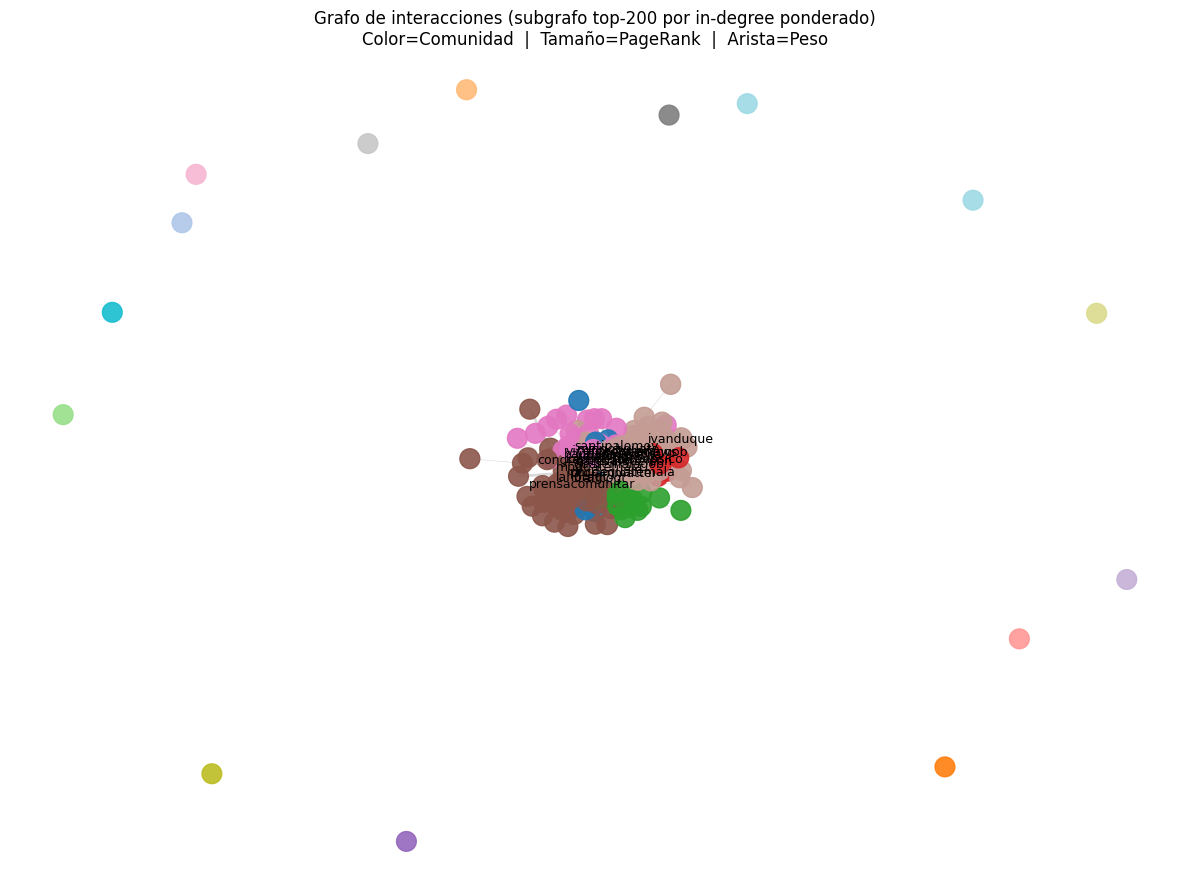

=== RESUMEN TOPOLOGÍA (5.1–5.2) ===
Nodos: 5,213  |  Aristas (dirigidas): 19,476  |  Densidad (dirigida): 0.000717
Coeficiente de agrupamiento (promedio, no dirigido): 0.3129
Diámetro (en el mayor componente no dirigido): 7
Interacciones por tipo: {'mention': 28035, 'reply': 8409}

Top 10 por in-degree ponderado:
           user  indegree_w  pagerank  betweenness
 barevalodeleon        5917  0.130507     0.567813
      traficogt        5622  0.071884     0.476992
   guatemalagob        1171  0.017698     0.030037
     ubaldomacu        1022  0.008834     0.013285
    mpguatemala         605  0.010947     0.019377
 fjimenezmingob         594  0.004777     0.002506
   santipalomov         526  0.005589     0.004210
      __vadertg         443  0.004515     0.007347
prensacomunitar         355  0.003922     0.003899
     olsenpsico         341  0.004660     0.006566

Top 10 por PageRank:
          user  pagerank  indegree_w  outdegree_w
barevalodeleon  0.130507        5917            0
  

In [7]:
# === Inciso 5 (5.1 + 5.2) — Topología de la red: construcción, visualización y métricas ===
# Requisitos:
#   - Haber generado 'eda_outputs/edges_mentions_replies_retweets.csv' en el inciso 4 (Celda A),
#     o bien tener 'df_proc' en memoria (reconstruiremos el edge list si hace falta).
# Qué hace:
#   1) Carga/arma aristas dirigidas (src -> dst) de menciones, replies y retweets (si existieran).
#   2) Construye un grafo dirigido con pesos (conteos de interacciones).
#   3) Calcula métricas clave: densidad, diámetro (en el mayor componente), coef. de agrupamiento,
#      in/out-degree (ponderados y no), PageRank y betweenness (aprox. para escalar).
#   4) Detecta comunidades (Louvain si disponible, si no Greedy Modularity) en un subgrafo top-200.
#   5) Visualiza el subgrafo (color = comunidad; tamaño = PageRank) y guarda artefactos.
#
# Al terminar, imprime un bloque: "=== RESUMEN TOPOLOGÍA (5.1–5.2) ==="
# Envíame ese bloque y te hago el análisis en Markdown.

import pandas as pd
import numpy as np
import os
from pathlib import Path
import re
import matplotlib.pyplot as plt
import networkx as nx

# -----------------------
# 0) Cargar el edge list
# -----------------------
def _norm_user(u):
    if u is None or (isinstance(u, float) and np.isnan(u)):
        return None
    u = str(u).strip()
    if not u:
        return None
    if u.startswith("@"):
        u = u[1:]
    return u.lower()

edges_path = Path("eda_outputs/edges_mentions_replies_retweets.csv")
if edges_path.exists():
    df_edges = pd.read_csv(edges_path)
else:
    # Fallback: reconstruir rápidamente desde df_proc si está en memoria
    if "df_proc" not in globals():
        raise RuntimeError("No encuentro 'eda_outputs/edges_mentions_replies_retweets.csv' ni 'df_proc'. Vuelve a ejecutar la Celda A del inciso 4.")
    rows = []
    for _, row in df_proc.iterrows():
        src = _norm_user(row.get("username"))
        if not src:
            continue
        # menciones
        for dst in (row.get("mentions") or []):
            dst = _norm_user(dst)
            if dst:
                rows.append((src, dst, "mention"))
        # reply
        dst = _norm_user(row.get("reply_to_user"))
        if dst:
            rows.append((src, dst, "reply"))
        # retweet
        if bool(row.get("is_retweet")) and row.get("retweeted_user"):
            dst = _norm_user(row.get("retweeted_user"))
            if dst:
                rows.append((src, dst, "retweet"))
    df_edges = pd.DataFrame(rows, columns=["src","dst","type"])

# Normalización básica
if "type" not in df_edges.columns:
    df_edges["type"] = "mention"
df_edges["src"] = df_edges["src"].apply(_norm_user)
df_edges["dst"] = df_edges["dst"].apply(_norm_user)
df_edges = df_edges.dropna(subset=["src","dst"])
df_edges = df_edges[df_edges["src"] != df_edges["dst"]]  # quita self-loops
df_edges["type"] = df_edges["type"].fillna("mention").str.lower()

# Conteo por tipo (para el resumen)
type_counts = df_edges.groupby("type").size().to_dict()

# Agregar pesos por (src,dst,type) y por (src,dst)
df_edges_type = (
    df_edges
    .groupby(["src","dst","type"], as_index=False)
    .size()
    .rename(columns={"size":"weight"})
)
df_edges_total = (
    df_edges
    .groupby(["src","dst"], as_index=False)
    .size()
    .rename(columns={"size":"weight"})
)

# ---------------------------------------
# 1) Construir grafo dirigido con pesos
# ---------------------------------------
G = nx.DiGraph()
for r in df_edges_type.itertuples(index=False):
    # Nota: si hay múltiples tipos para el mismo par, añadimos/actualizamos acumulando peso total en 'weight'
    if G.has_edge(r.src, r.dst):
        G[r.src][r.dst]["weight"] = G[r.src][r.dst].get("weight", 0) + r.weight
        # Guardamos una lista de tipos para referencia
        prev_types = set(G[r.src][r.dst].get("types", []))
        prev_types.add(r.type)
        G[r.src][r.dst]["types"] = list(prev_types)
    else:
        G.add_edge(r.src, r.dst, weight=r.weight, types=[r.type])

n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges()
density_dir = nx.density(G)  # m / (n*(n-1))

# ----------------------------------------------------
# 2) Métricas: clustering, diámetro y componentes
# ----------------------------------------------------
# Usamos versión no dirigida para clustering/diámetro
Gu = G.to_undirected()
avg_clustering = nx.average_clustering(Gu) if n_nodes > 0 else float("nan")

# Diámetro en el mayor componente conexo (no dirigido)
diameter_val = None
if n_nodes > 1 and n_edges > 0:
    cc = list(nx.connected_components(Gu))
    if cc:
        largest_cc_nodes = max(cc, key=len)
        Gcc = Gu.subgraph(largest_cc_nodes).copy()
        try:
            # Si el componente no es muy grande, cálculo exacto
            if Gcc.number_of_nodes() <= 2000:
                diameter_val = nx.diameter(Gcc)
            else:
                # Aproximación para grafos grandes
                from networkx.algorithms.approximation.distance_measures import diameter as approx_diameter
                diameter_val = approx_diameter(Gcc)
        except Exception:
            diameter_val = None

# ----------------------------------------------------
# 3) Centralidades y rankings
# ----------------------------------------------------
# In/Out-degree (no ponderado y ponderado)
in_deg = dict(G.in_degree(weight=None))
out_deg = dict(G.out_degree(weight=None))
in_deg_w = dict(G.in_degree(weight="weight"))
out_deg_w = dict(G.out_degree(weight="weight"))

# PageRank (ponderado)
pagerank = nx.pagerank(G, alpha=0.85, weight="weight") if n_nodes > 0 else {}

# Betweenness aproximado (no dirigido) para escalar mejor
k_sample = min(500, max(10, int(n_nodes * 0.2)))  # muestreo de pivotes
try:
    betw = nx.betweenness_centrality(Gu, k=k_sample, seed=42)
except Exception:
    betw = {}

# DataFrame de métricas por nodo
metrics = pd.DataFrame({"user": list(G.nodes())})
metrics["indegree"] = metrics["user"].map(in_deg).fillna(0).astype(int)
metrics["outdegree"] = metrics["user"].map(out_deg).fillna(0).astype(int)
metrics["indegree_w"] = metrics["user"].map(in_deg_w).fillna(0).astype(int)
metrics["outdegree_w"] = metrics["user"].map(out_deg_w).fillna(0).astype(int)
metrics["pagerank"] = metrics["user"].map(pagerank).fillna(0.0)
metrics["betweenness"] = metrics["user"].map(betw).fillna(0.0)

# ----------------------------------------------------
# 4) Comunidades y visualización (subgrafo top-200)
# ----------------------------------------------------
topN = 200
top_nodes = (
    metrics.sort_values(["indegree_w","pagerank"], ascending=False)
           .head(topN)["user"]
           .tolist()
)
H = G.subgraph(top_nodes).copy()
Hu = H.to_undirected()

# Detección de comunidades
try:
    from networkx.algorithms.community import louvain_communities
    comms = louvain_communities(Hu, seed=42)
except Exception:
    from networkx.algorithms.community import greedy_modularity_communities
    comms = list(greedy_modularity_communities(Hu))

comm_map = {}
for cid, com in enumerate(comms):
    for n in com:
        comm_map[n] = cid

# Layout y dibujo
pos = nx.spring_layout(Hu, seed=42)
node_sizes = []
for n in Hu.nodes():
    pr = metrics.loc[metrics["user"] == n, "pagerank"]
    pr = pr.values[0] if len(pr) else 0.0
    node_sizes.append(200 + 8000 * pr)  # tamaño ~ PageRank

node_colors = [comm_map.get(n, -1) for n in Hu.nodes()]
edge_widths = [max(0.4, min(4.0, H[u][v].get("weight",1) / 5.0)) for u,v in H.edges()]

out_dir = Path("net_outputs"); out_dir.mkdir(exist_ok=True)

plt.figure(figsize=(12, 9))
nx.draw_networkx_edges(Hu, pos, alpha=0.15, width=edge_widths)
nodes = nx.draw_networkx_nodes(Hu, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.tab20, alpha=0.9)
# Etiquetas solo para los 20 nodos con mayor indegree ponderado
label_nodes = (
    metrics.sort_values("indegree_w", ascending=False)
           .head(20)["user"].tolist()
)
nx.draw_networkx_labels(Hu, pos, labels={n:n for n in Hu.nodes() if n in label_nodes}, font_size=9)
plt.title("Grafo de interacciones (subgrafo top-200 por in-degree ponderado)\nColor=Comunidad  |  Tamaño=PageRank  |  Arista=Peso")
plt.axis("off")
plt.tight_layout()
plt.savefig(out_dir / "graph_top200.png", dpi=180)
plt.show()

# ----------------------------------------------------
# 5) Guardar artefactos y reportar resumen
# ----------------------------------------------------
metrics.sort_values("indegree_w", ascending=False).to_csv(out_dir / "node_metrics.csv", index=False)
df_edges_total.to_csv(out_dir / "edge_weights.csv", index=False)

print("=== RESUMEN TOPOLOGÍA (5.1–5.2) ===")
print(f"Nodos: {n_nodes:,}  |  Aristas (dirigidas): {n_edges:,}  |  Densidad (dirigida): {density_dir:.6f}")
print(f"Coeficiente de agrupamiento (promedio, no dirigido): {avg_clustering:.4f}")
print("Diámetro (en el mayor componente no dirigido):", "N/A" if diameter_val is None else diameter_val)
print("Interacciones por tipo:", type_counts)

print("\nTop 10 por in-degree ponderado:")
print(metrics.sort_values("indegree_w", ascending=False).head(10)[["user","indegree_w","pagerank","betweenness"]].to_string(index=False))

print("\nTop 10 por PageRank:")
print(metrics.sort_values("pagerank", ascending=False).head(10)[["user","pagerank","indegree_w","outdegree_w"]].to_string(index=False))

print("\nTop 10 por betweenness (aprox, no dirigido):")
print(metrics.sort_values("betweenness", ascending=False).head(10)[["user","betweenness","indegree_w","outdegree_w"]].to_string(index=False))

print("\nArtefactos guardados en:", str(out_dir.resolve()))
print(" - net_outputs/graph_top200.png")
print(" - net_outputs/node_metrics.csv")
print(" - net_outputs/edge_weights.csv")


# Inciso 5 — Análisis de la topología de la red (menciones + respuestas)

> **Datos del grafo**  
> Nodos: **5,213** · Aristas dirigidas: **19,476** · **Densidad**: 0.000717  
> **Coef. de agrupamiento (promedio, no dirigido)**: **0.3129** · **Diámetro** (mayor componente): **7**  
> **Interacciones por tipo**: menciones = **28,035**, respuestas = **8,409** (RT nativos no presentes en la muestra)

---

## 5.1 Construcción y visualización de grafos

- La visualización del **subgrafo top-200 por in-degree ponderado** muestra un **núcleo denso** donde se concentran las interacciones y múltiples **comunidades** (colores distintos).  
  - Nodos etiquetados visibles: `barevalodeleon`, `traficogt`, `guatemalagob`, `mpguatemala`, etc.  
  - Los **nodos periféricos** alrededor del dibujo aparecen aislados porque, aunque reciben muchas interacciones desde *fuera* del top-200, **no forman lazos fuertes entre sí** dentro de este subgrafo.
- **Baja densidad (0.000717)**: típica de redes de mención/respuesta a gran escala (sparsas) donde pocos pares se conectan directamente.
- **Agrupamiento medio alto (0.313)**: sugiere **formación de clústeres**/comunidades locales (p. ej., cuentas institucionales, medios, activismo).
- **Diámetro = 7** sobre el mayor componente: propiedad **“small-world”** — la mayoría de los nodos se conectan en pocos saltos a través de hubs.

**Lectura de poder / visibilidad en la figura**
- El **tamaño** (PageRank) y la **posición central** del núcleo resaltan a **@barevalodeleon** y **@traficogt** como focos de atención.  
- La mezcla de colores cerca del núcleo indica que **varias comunidades** están **acopladas** por estos hubs (actúan como puntos de convergencia entre grupos temáticos).

---

## 5.2 Métricas de red clave e interpretación

### Hubs de atención (in-degree ponderado)
Top por **indegree_w**:
1. **@barevalodeleon** (5,917) — PR **0.1305**, betweenness **0.5678**, **outdegree_w = 0**  
2. **@traficogt** (5,622) — PR **0.0719**, betweenness **0.4770**, **outdegree_w = 150**  
3. **@guatemalagob** (1,171) — PR **0.0177**  
4. **@ubaldomacu** (1,022) — PR **0.0088**  
5. **@mpguatemala** (605) — PR **0.0109**

**Insight**  
- **@barevalodeleon** y **@traficogt** concentran **gran parte de las menciones/respuestas**.  
  - `@barevalodeleon` domina en **in-degree** y **PageRank** aun con **cero salida**, típico de **“sumidero” de atención** (muchos hablan *a* él/ella, casi no responde).  
  - `@traficogt` combina **alta atención** con **actividad de salida** (outdegree_w=150), perfil de **difusor** que además conecta comunidades.

### Influencia estructural (PageRank y betweenness)
Top por **PageRank** incluye, además de los dos anteriores, cuentas **institucionales**:
- `@guatemalagob`, `@drgiammattei`, `@mpguatemala`, `@cc_guatemala`, `@usaidguate`, `@ivanduque`.  
→ Indica que, aun sin ser los más mencionados, **canalizan flujos de interacción** relevantes en el grafo.

Top por **betweenness** (puentes):
- Además de `@barevalodeleon` y `@traficogt`, destacan **@mildred_gaitan** y **@batallonjalapa** con **betweenness alto** pero **indegree bajo** y **outdegree muy alto** (398 y 461).  
→ **Nodos “conectores”**: responden a muchos y **unen clusters** que de otro modo quedarían separados (posible activismo/brigadas de respuesta, cuentas muy conversacionales o coordinadores).

### Conclusión de métricas
- La red está **altamente centralizada** en dos hubs principales, con **comunidades bien definidas** alrededor de **instituciones** y **figuras públicas**.  
- La combinación de **clustering elevado** y **diámetro corto** confirma un **patrón small-world**: pocos nodos estratégicos bastan para conectar a la mayoría.  
- La ausencia de RT nativos en los datos **desplaza la noción de difusión** hacia **menciones y respuestas**; aun así, los **hubs y conectores** emergen con claridad.

---

## Recomendaciones de profundización

1. **Comunidades**: cuantificar tamaños y etiquetarlas por **hashtags/tokens predominantes** para perfilar temas (Louvain/Leiden).  
2. **Roles**: contrastar **indegree_w vs. outdegree_w** para clasificar **sumideros de atención**, **difusores** y **conectores**.  
3. **Evolución**: repetir métricas por **ventanas temporales** (mensual/semanal) para detectar **picos** y **cambios de liderazgo**.  
4. **Robustez**: si se dispone de RTs nativos en otra extracción, incorporar **retweets** para medir **alcance** y **cascadeo**.



# Inciso 6


## 6.1. Identificación y análisis de comunidades (elección del algoritmo)

### ¿Qué algoritmo usar?

El **método Louvain** (Blondel et al., 2008) es el estándar histórico más difundido para detección de comunidades por su rapidez y calidad al optimizar modularidad; aparece en reseñas clásicas y está disponible en librerías comunes (e.g., *NetworkX*), lo que facilita la reproducibilidad.  

**Referencias:**
- [arXiv](https://arxiv.org/)


---




In [1]:
# 6.1 — Detección de comunidades con Louvain (y fallback a Greedy Modularity)

import os
import pandas as pd
import networkx as nx

# ---------- 1) Localizar el archivo de aristas ----------
CANDIDATES = [
    "net_outputs/edge_weights.csv",                  # si el notebook está en lab6ds/
    "../net_outputs/edge_weights.csv",               # si el notebook está en lab6ds/notebooks/
    "lab6ds/net_outputs/edge_weights.csv",           # si ejecutas desde la raíz del zip
    "./edge_weights.csv",                            # último recurso (por si moviste el archivo)
]

edges_path = None
for p in CANDIDATES:
    if os.path.exists(p):
        edges_path = p
        break

if edges_path is None:
    raise FileNotFoundError("No se encontró 'edge_weights.csv'. Ajusta la ruta en CANDIDATES.")

print(f"Usando archivo de aristas: {edges_path}")

# ---------- 2) Cargar aristas y construir el grafo dirigido ----------
edges = pd.read_csv(edges_path)
edges.columns = [c.strip().lower() for c in edges.columns]

# Aceptamos nombres de columnas comunes
col_src = "src" if "src" in edges.columns else ("source" if "source" in edges.columns else None)
col_dst = "dst" if "dst" in edges.columns else ("target" if "target" in edges.columns else None)
col_w  = "weight" if "weight" in edges.columns else None

assert col_src and col_dst and col_w, f"Se esperaban columnas tipo src/dst/weight; columnas reales: {edges.columns.tolist()}"

G_directed = nx.DiGraph()
for row in edges.itertuples(index=False):
    G_directed.add_edge(getattr(row, col_src), getattr(row, col_dst), weight=float(getattr(row, col_w)))

print(f"Grafo dirigido: {G_directed.number_of_nodes()} nodos, {G_directed.number_of_edges()} aristas")

# ---------- 3) Proyección no dirigida ponderada ----------
G_undirected = nx.Graph()
for u, v, d in G_directed.edges(data=True):
    w = float(d.get("weight", 1.0))
    if G_undirected.has_edge(u, v):
        G_undirected[u][v]["weight"] += w
    else:
        G_undirected.add_edge(u, v, weight=w)

print(f"Grafo NO dirigido para comunidades: {G_undirected.number_of_nodes()} nodos, {G_undirected.number_of_edges()} aristas")

# ---------- 4) Ejecutar Louvain (o fallback) ----------
algo_used = None
communities_list = None

try:
    # NetworkX >= 2.6: louvain_communities
    from networkx.algorithms.community import louvain_communities
    communities_list = louvain_communities(G_undirected, weight="weight", resolution=1.0, seed=42)
    algo_used = "Louvain (NetworkX)"
except Exception as e:
    # Fallback: greedy_modularity_communities
    from networkx.algorithms.community import greedy_modularity_communities
    communities_list = greedy_modularity_communities(G_undirected, weight="weight")
    algo_used = "Greedy Modularity (fallback)"
    print(f"[Aviso] Louvain no disponible ({e}). Usando {algo_used}.")

# communities_list es una lista de 'sets' de nodos
num_com = len(communities_list)
sizes = sorted([len(c) for c in communities_list], reverse=True)
print(f"Algoritmo: {algo_used}. Comunidades detectadas: {num_com}")
print("Tamaños de las 10 comunidades más grandes:", sizes[:10])

# ---------- 5) Asignación nodo -> comunidad y resumen ----------
node2community = {}
for cid, com in enumerate(communities_list):
    for n in com:
        node2community[n] = cid

communities_df = pd.DataFrame(
    [{"user": n, "community": node2community[n]} for n in G_undirected.nodes()]
).sort_values(["community","user"]).reset_index(drop=True)

sizes_df = (
    communities_df.groupby("community", as_index=False)
    .size()
    .rename(columns={"size": "size_nodes"})
    .sort_values("size_nodes", ascending=False)
    .reset_index(drop=True)
)

# ---------- 6) Moduralidad (calidad de la partición) ----------
from networkx.algorithms.community.quality import modularity
mod_score = modularity(G_undirected, communities_list, weight="weight")

print(f"Modularidad de la partición: {mod_score:.4f}")

# ---------- 7) Mostrar cabezales útiles ----------
display(sizes_df.head(10))
display(communities_df.head(10))

# Objetos que usaremos en 6.2/6.3
RESULTS_61 = {
    "G_directed": G_directed,
    "G_undirected": G_undirected,
    "communities_list": communities_list,   # lista de sets
    "node2community": node2community,       # dict user -> comunidad
    "communities_df": communities_df,       # tabla asignación
    "sizes_df": sizes_df,                   # tamaños
    "modularity": mod_score,
    "algo_used": algo_used,
}


Usando archivo de aristas: net_outputs/edge_weights.csv
Grafo dirigido: 5213 nodos, 19476 aristas
Grafo NO dirigido para comunidades: 5213 nodos, 19294 aristas
Algoritmo: Louvain (NetworkX). Comunidades detectadas: 42
Tamaños de las 10 comunidades más grandes: [1635, 1182, 326, 252, 220, 201, 196, 192, 178, 170]
Modularidad de la partición: 0.4952


,community,size_nodes
0,3,1635
1,38,1182
2,33,326
3,32,252
4,37,220
5,1,201
6,36,196
7,30,192
8,8,178
9,7,170


,user,community
0,aler337268,0
1,claucastillo45,0
2,stevekazuo,0
3,t1eetc_noticias,0
4,1994meola,1
5,230221abogado,1
6,9102ramoto,1
7,__keev_,1
8,__m1ng0__,1
9,__vadergt,1


## 6.2. Visualización y caracterización de comunidades

1. Partimos de los resultados del **6.1** (`RESULTS_61` con `G_directed`, `G_undirected`, `communities_list`, `node2community`, etc.).  
2. Hacemos una **vista general** (subgrafo con los nodos de mayor grado para legibilidad), coloreando por comunidad.  
3. Graficamos solo las **3 comunidades más grandes**, dimensionando nodos por **PageRank** (en el subgrafo dirigido de esas comunidades) para sugerir influencia.  
4. Calculamos, por comunidad:  
   - `size_nodes`  
   - Aristas internas dirigidas (conteo y peso)  
   - Aristas externas (entrantes/salientes y sus pesos)  
   - Densidad (subgrafo no dirigido)  
5. Top-5 usuarios por **indegree local ponderado** (nodos más citados/etiquetados dentro de su comunidad).  
6. Tomamos tokens de `tweets_clean_sample.csv` y listamos **términos frecuentes** por comunidad (aprox.) para las **Top-3**.  

---

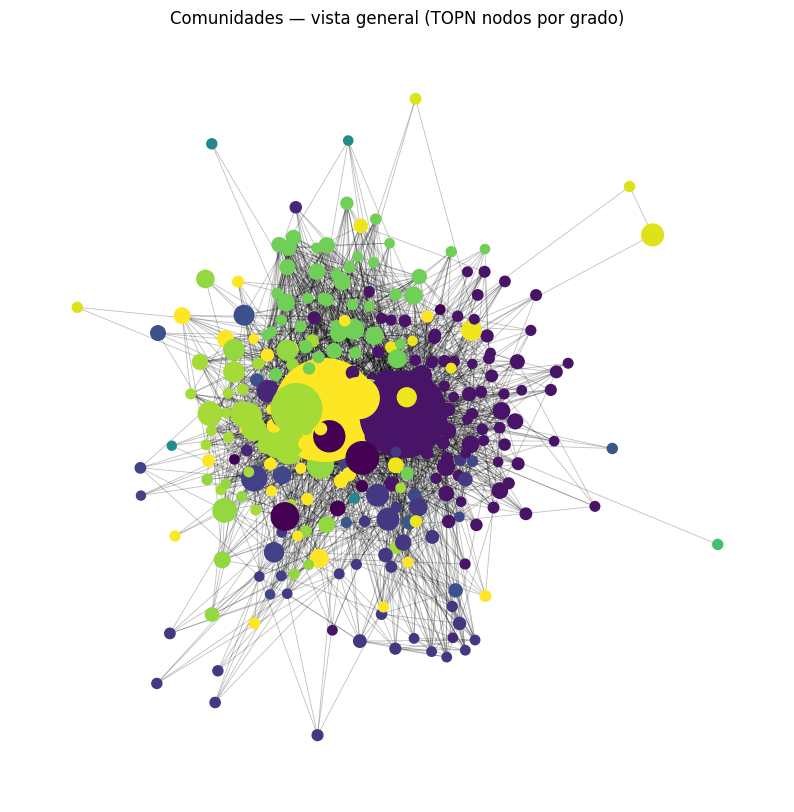

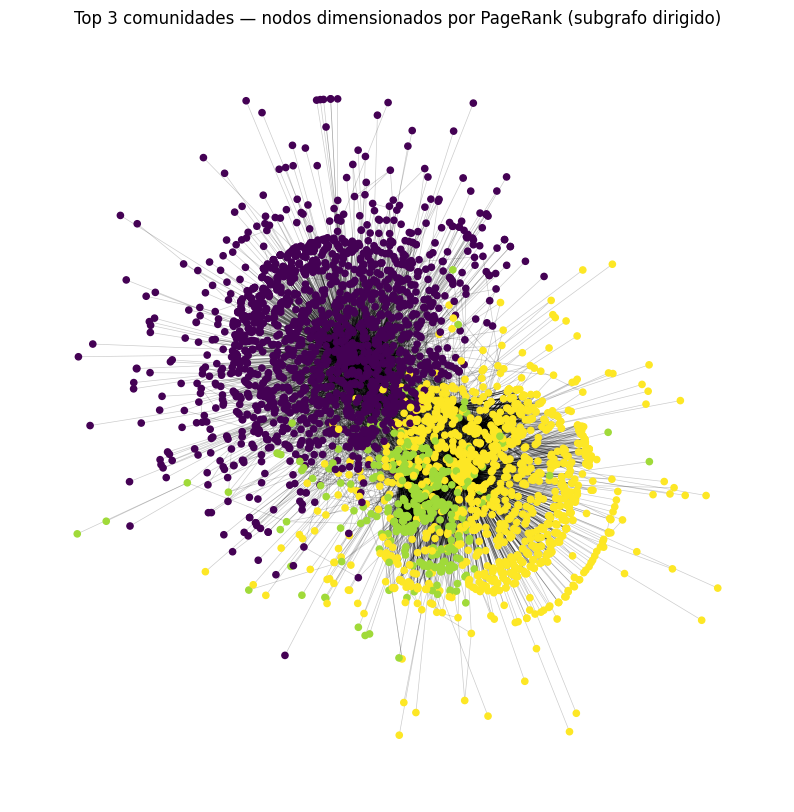

IDs de las 3 comunidades más grandes: [3, 38, 33]


In [2]:
# 6.2.A — Visualización de comunidades
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# ==== 1) Recuperar resultados del 6.1 o reconstruir mínimo si no existen ====
def _rebuild_from_edges():
    CANDIDATES = [
        "net_outputs/edge_weights.csv",
        "../net_outputs/edge_weights.csv",
        "lab6ds/net_outputs/edge_weights.csv",
        "./edge_weights.csv",
    ]
    edges_path = next((p for p in CANDIDATES if os.path.exists(p)), None)
    if edges_path is None:
        raise FileNotFoundError("No se encontró edge_weights.csv; ajusta rutas en CANDIDATES.")

    edges = pd.read_csv(edges_path)
    edges.columns = [c.strip().lower() for c in edges.columns]
    col_src = "src" if "src" in edges.columns else ("source" if "source" in edges.columns else None)
    col_dst = "dst" if "dst" in edges.columns else ("target" if "target" in edges.columns else None)
    col_w  = "weight" if "weight" in edges.columns else None
    assert col_src and col_dst and col_w, f"Columnas esperadas tipo src/dst/weight; reales: {edges.columns.tolist()}"

    Gd = nx.DiGraph()
    for r in edges.itertuples(index=False):
        Gd.add_edge(getattr(r, col_src), getattr(r, col_dst), weight=float(getattr(r, col_w)))
    Gu = nx.Graph()
    for u, v, d in Gd.edges(data=True):
        w = float(d.get("weight", 1.0))
        if Gu.has_edge(u, v):
            Gu[u][v]["weight"] += w
        else:
            Gu.add_edge(u, v, weight=w)

    from networkx.algorithms.community import louvain_communities
    comms = louvain_communities(Gu, weight="weight", seed=42)
    node2com = {}
    for cid, com in enumerate(comms):
        for n in com:
            node2com[n] = cid
    sizes_df = (
        pd.DataFrame({"user": list(node2com.keys()), "community": list(node2com.values())})
        .groupby("community", as_index=False).size()
        .rename(columns={"size": "size_nodes"})
        .sort_values("size_nodes", ascending=False)
        .reset_index(drop=True)
    )
    return Gd, Gu, comms, node2com, sizes_df

try:
    Gu = RESULTS_61["G_undirected"]
    Gd = RESULTS_61["G_directed"]
    communities_list = RESULTS_61["communities_list"]
    node2community = RESULTS_61["node2community"]
    sizes_df = RESULTS_61["sizes_df"]
except NameError:
    Gd, Gu, communities_list, node2community, sizes_df = _rebuild_from_edges()

# ==== 2) Vista general (subgrafo con TOPN nodos por grado) ====
TOPN = 300  # ajusta si quieres más/menos nodos
deg = dict(Gu.degree())
top_nodes = sorted(deg, key=deg.get, reverse=True)[:min(TOPN, Gu.number_of_nodes())]
H = Gu.subgraph(top_nodes).copy()

pos = nx.spring_layout(H, seed=42, iterations=50)
node_colors = [node2community.get(n, -1) for n in H.nodes()]  # un entero por comunidad
node_sizes = [10 + 2*deg.get(n, 1) for n in H.nodes()]        # tamaño proporcional al grado (suave)

plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(H, pos, node_size=node_sizes, node_color=node_colors)
nx.draw_networkx_edges(H, pos, alpha=0.25, width=0.6)
plt.title("Comunidades — vista general (TOPN nodos por grado)")
plt.axis("off")
plt.show()

# ==== 3) Gráfico con las 3 comunidades más grandes ====
top3_ids = sizes_df.sort_values("size_nodes", ascending=False).head(3)["community"].tolist()
nodes_top3 = [n for n,cid in node2community.items() if cid in top3_ids]
H3_u = Gu.subgraph(nodes_top3).copy()
H3_d = Gd.subgraph(nodes_top3).copy()

# PageRank (dirigido; ponderado por 'weight') para destacar influencia en el gráfico
pr = nx.pagerank(H3_d, alpha=0.85, weight="weight", max_iter=100)
pr_min, pr_max = (min(pr.values()), max(pr.values())) if pr else (0, 1)

# tamaños escalados por PageRank (evitar casos extremos)
def scale_size(x, xmin, xmax, smin=20, smax=300):
    if xmax == xmin:
        return (smin + smax) / 2.0
    return smin + (smax - smin) * ((x - xmin) / (xmax - xmin))

sizes_pr = [scale_size(pr.get(n, 0), pr_min, pr_max, smin=20, smax=300) for n in H3_u.nodes()]
colors_3 = [node2community.get(n, -1) for n in H3_u.nodes()]

pos3 = nx.spring_layout(H3_u, seed=123, iterations=60)
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(H3_u, pos3, node_size=sizes_pr, node_color=colors_3)
nx.draw_networkx_edges(H3_u, pos3, alpha=0.2, width=0.5)
plt.title("Top 3 comunidades — nodos dimensionados por PageRank (subgrafo dirigido)")
plt.axis("off")
plt.show()

print("IDs de las 3 comunidades más grandes:", top3_ids)


In [3]:
# 6.2.B — Caracterización por comunidad: tamaño, interacciones, top usuarios y temas (aprox.)

import ast
import pandas as pd
import networkx as nx
from collections import Counter

# ==== 1) Tablas de interacción por comunidad ====
# - internal_edges_*: aristas con (u,v) dentro de la comunidad (conteo y suma de pesos)
# - outgoing_*: desde la comunidad hacia fuera
# - incoming_*: desde fuera hacia la comunidad
# - density_undirected: densidad en subgrafo no dirigido

rows = []
node2community = dict(node2community)  # asegurar dict normal
for cid, com in enumerate(communities_list):
    com = set(com)
    # Subgrafos
    sub_u = Gu.subgraph(com).copy()

    # Contadores
    internal_count = 0
    outgoing_count = 0
    incoming_count = 0
    internal_w = 0.0
    outgoing_w = 0.0
    incoming_w = 0.0

    # Recorremos aristas dirigidas del grafo completo
    for u, v, d in Gd.edges(data=True):
        w = float(d.get("weight", 1.0))
        u_in, v_in = u in com, v in com
        if u_in and v_in:
            internal_count += 1
            internal_w += w
        elif u_in and not v_in:
            outgoing_count += 1
            outgoing_w += w
        elif (not u_in) and v_in:
            incoming_count += 1
            incoming_w += w

    # indegree local ponderado (quién recibe más peso desde su propia comunidad)
    indeg_local = {}
    for u, v, d in Gd.in_edges(list(com), data=True):
        if u in com and v in com:
            indeg_local[v] = indeg_local.get(v, 0.0) + float(d.get("weight", 1.0))
    top5_local = sorted(indeg_local.items(), key=lambda x: x[1], reverse=True)[:5]

    rows.append({
        "community": cid,
        "size_nodes": len(com),
        "density_undirected": nx.density(sub_u),
        "internal_edges_count": internal_count,
        "internal_edges_weight": internal_w,
        "outgoing_edges_count": outgoing_count,
        "outgoing_edges_weight": outgoing_w,
        "incoming_edges_count": incoming_count,
        "incoming_edges_weight": incoming_w,
        "top5_users_by_local_indegree": "; ".join([f"{u}:{w:.0f}" for u,w in top5_local]),
    })

char_df = pd.DataFrame(rows).sort_values("size_nodes", ascending=False).reset_index(drop=True)
display(char_df.head(10))

# ==== 2) Temas principales (aprox.) por comunidad usando tokens de la muestra limpia ====
# Intentamos localizar tweets_clean_sample.csv:
CANDS = [
    "tweets_clean_sample.csv",
    "../tweets_clean_sample.csv",
    "lab6ds/tweets_clean_sample.csv",
]
clean_path = next((p for p in CANDS if os.path.exists(p)), None)
if clean_path is None:
    print("[Aviso] No se encontró tweets_clean_sample.csv; omitiendo temas.")
else:
    clean = pd.read_csv(clean_path)
    # Normalizamos username para cruzar
    clean["username_norm"] = clean["username"].astype(str).str.lower()
    # Lista de tokens
    def parse_list(s):
        try:
            return ast.literal_eval(s)
        except Exception:
            return []
    clean["tokens_list"] = clean["tokens_nostop"].astype(str).apply(parse_list)

    # Mapeo user -> comunidad
    u2c = pd.DataFrame({"user": list(node2community.keys()),
                        "community": list(node2community.values())})
    u2c["user"] = u2c["user"].astype(str).str.lower()

    merged = clean.merge(u2c, left_on="username_norm", right_on="user", how="left").dropna(subset=["community"])

    # Top-3 comunidades por tamaño
    top3_ids = char_df.head(3)["community"].tolist()

    topic_rows = []
    for cid in top3_ids:
        toks = []
        for lst in merged.loc[merged["community"]==cid, "tokens_list"]:
            toks.extend([t for t in lst if isinstance(t, str)])
        # Conteo y filtrito mínimo
        cnt = Counter(toks)
        common = [f"{w}:{c}" for w,c in cnt.most_common(15)]
        topic_rows.append({"community": cid, "top_terms": ", ".join(common)})

    topics_df = pd.DataFrame(topic_rows)
    display(topics_df)

# Guardamos resultados en variable para próximos incisos
RESULTS_62 = {
    "char_df": char_df,
    "topics_df": topics_df if clean_path is not None else None
}


,community,size_nodes,density_undirected,internal_edges_count,internal_edges_weight,outgoing_edges_count,outgoing_edges_weight,incoming_edges_count,incoming_edges_weight,top5_users_by_local_indegree
0,3,1635,0.002640,3548,8664.0,1428,2299.0,1437,2424.0,traficogt:4193; prensacomunitar:261; lahoragt:...
1,38,1182,0.003778,2686,5830.0,1091,1879.0,2389,4410.0,barevalodeleon:2691; ubaldomacu:786; santipalo...
2,33,326,0.026899,1443,2500.0,718,1391.0,930,1377.0,guatemalagob:480; fjimenezmingob:392; diariode...
3,32,252,0.023209,744,1185.0,610,1000.0,408,595.0,vicentecarrera_:288; uclcgt:148; drgiammattei:...
4,37,220,0.015899,389,709.0,299,454.0,222,295.0,amilcarmontejo:179; muniguate:70; aztecanotici...
5,1,201,0.027612,563,846.0,387,581.0,238,361.0,__vadertg:306; congresoguate:184; usaidguate:1...
6,36,196,0.011408,218,369.0,139,149.0,10,12.0,ivanduque:240; petrogustavo:10; jmilei:7; just...
7,30,192,0.047175,871,1181.0,688,1301.0,307,479.0,jczamora:177; plazapublicagt:56; ojguatemala:5...
8,8,178,0.020250,324,580.0,366,600.0,251,379.0,elquenews:243; bancadasemilla:101; avillagran5...
9,7,170,0.037243,548,911.0,422,688.0,373,576.0,samuel_pz:87; emisorasunidas:86; jlfont001:69;...


,community,top_terms
0,3,"traficogt:123, gt:17, quorumgt:15, pialaperiod..."
1,38,"traficogt:5, género:2, investigación:2, fiscal..."
2,33,"traficogt:2, lionelgaliano:1, landivarianos:1,..."
